# Setting Up Forecast

In [139]:
!pip install gluonts

     |████████████████████████████████| 2.5 MB 21.8 MB/s            
     |████████████████████████████████| 11.1 MB 52.9 MB/s            
     |████████████████████████████████| 179 kB 75.3 MB/s            
     |████████████████████████████████| 47 kB 8.5 MB/s             
     |████████████████████████████████| 5.4 MB 70.4 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730973 sha256=f0077b6df3141fcd79398fbf15e9ca77825987ef316458868e09dc98d5fc6988
  Stored in directory: /home/ec2-user/.cache/pip/wheels/33/6b/a6/1d9dae2323750f635654952afc74aa8f2d982cded163f43895
Successfully built pymeeus
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [157]:
import sys
import os
import shutil
import datetime
import pandas as pd
import numpy as np
import boto3

sys.path.insert(0, os.path.abspath("../../common") )
import util

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
region = 'us-east-1'
bucket_name = 'byj'

In [3]:
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [4]:
role_name = "ForecastRole"
role_arn = util.get_or_create_iam_role(role_name=role_name )

The role ForecastRole already exists, skipping creation
Done.


In [5]:
forecast.list_predictors()

{'Predictors': [{'PredictorArn': 'arn:aws:forecast:us-east-1:688520471316:predictor/my_gs_predictor_01G5SF9Y5J4JSQ0X3SC1V2VE55',
   'PredictorName': 'my_gs_predictor',
   'DatasetGroupArn': 'arn:aws:forecast:us-east-1:688520471316:dataset-group/my_dsgroup',
   'IsAutoPredictor': True,
   'Status': 'ACTIVE',
   'CreationTime': datetime.datetime(2022, 6, 17, 18, 37, 46, 34000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2022, 6, 17, 21, 1, 34, 164000, tzinfo=tzlocal())}],
 'ResponseMetadata': {'RequestId': '2b4ebe55-64fc-4a41-9902-53296d4f0c72',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 07 Jul 2022 02:01:06 GMT',
   'x-amzn-requestid': '2b4ebe55-64fc-4a41-9902-53296d4f0c72',
   'content-length': '360',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Read Data

In [6]:
df_regions = ["Aotizhongxin", "Changping", "Dingling", "Dongsi", "Guanyuan", "Gucheng", "Huairou", "Nongzhanguan", "Shunyi", "Tiantan", "Wanliu", "Wanshouxigong"]
df_raw = [pd.read_csv(f"../data/PRSA_Data_{region}_20130301-20170228.csv") for region in df_regions]

In [7]:
for df in df_raw:
    print(df.shape)

(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)


In [8]:
for df in df_raw:
    df.insert(0, "timestamp", pd.to_datetime(df[['year', 'month', 'day', 'hour']]))
    df.drop(['year', 'month', 'day', 'hour'], axis = 1, inplace = True)
    start_time = df.timestamp.min()
    end_time = df.timestamp.max()
    print(f"start time: {start_time}")
    print(f"end time: {end_time}")

start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00
start time: 2013-03-01 00:00:00
end time: 2017-02-28 23:00:00


[]

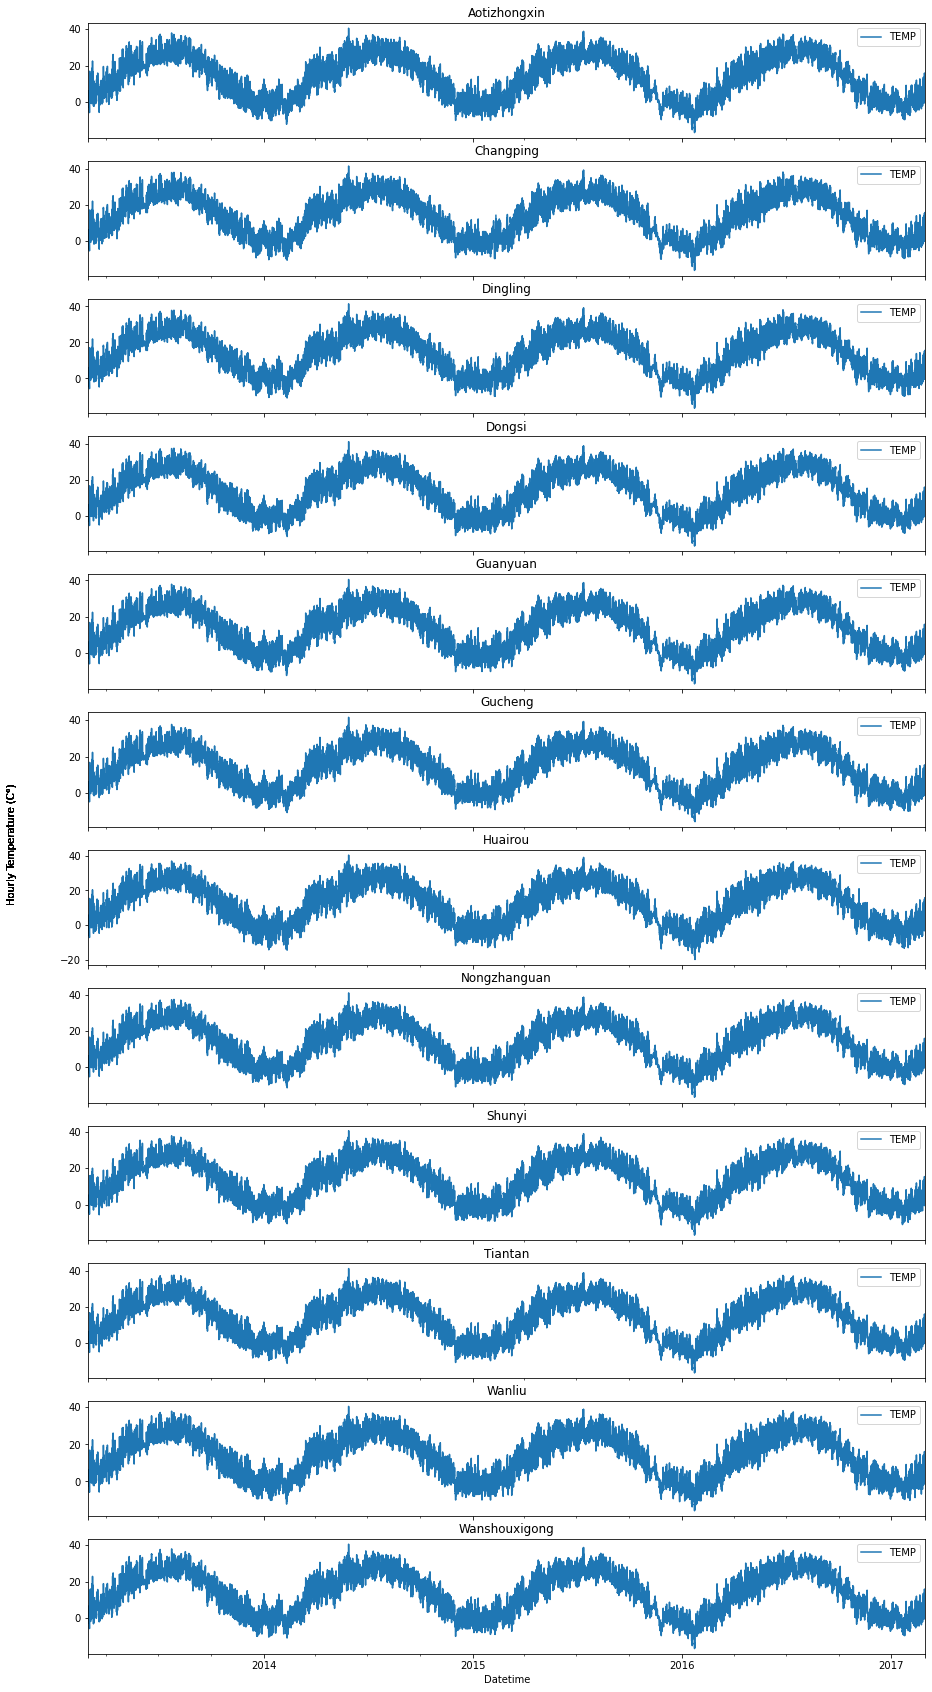

In [9]:
fig, axs = plt.subplots(len(df_regions), 1, figsize=(15, 30), sharex=True)

for i in range(len(df_raw)):
    
    df_raw[i].plot(x='timestamp', y='TEMP', ax = axs[i])
    
    axs[i].set_title(f"{df_regions[i]}")
    fig.text(0.05, 0.5, 'Hourly Temperature (C°)', va='center', rotation='vertical')
    axs[i].set_xlabel("Datetime") 
    
plt.plot()

Since each test site is located in the same city (Beijing), we can see similar trends in each dataset.

# Preparing Data

In [10]:
df_forecast = pd.concat(df_raw)[["timestamp","TEMP","station"]]
df_forecast_train = df_forecast[(df_forecast['timestamp'] >= '2013-03-01') & (df_forecast['timestamp'] < '2017-02-09')]
df_forecast_test = df_forecast[(df_forecast['timestamp'] >= '2017-02-09')]

In [57]:
df_forecast_train

,timestamp,TEMP,station
0,2013-03-01 00:00:00,-0.7,Aotizhongxin
1,2013-03-01 01:00:00,-1.1,Aotizhongxin
2,2013-03-01 02:00:00,-1.1,Aotizhongxin
3,2013-03-01 03:00:00,-1.4,Aotizhongxin
4,2013-03-01 04:00:00,-2.0,Aotizhongxin
...,...,...,...
34579,2017-02-08 19:00:00,-0.7,Wanshouxigong
34580,2017-02-08 20:00:00,-1.4,Wanshouxigong
34581,2017-02-08 21:00:00,-2.5,Wanshouxigong
34582,2017-02-08 22:00:00,-2.8,Wanshouxigong


[]

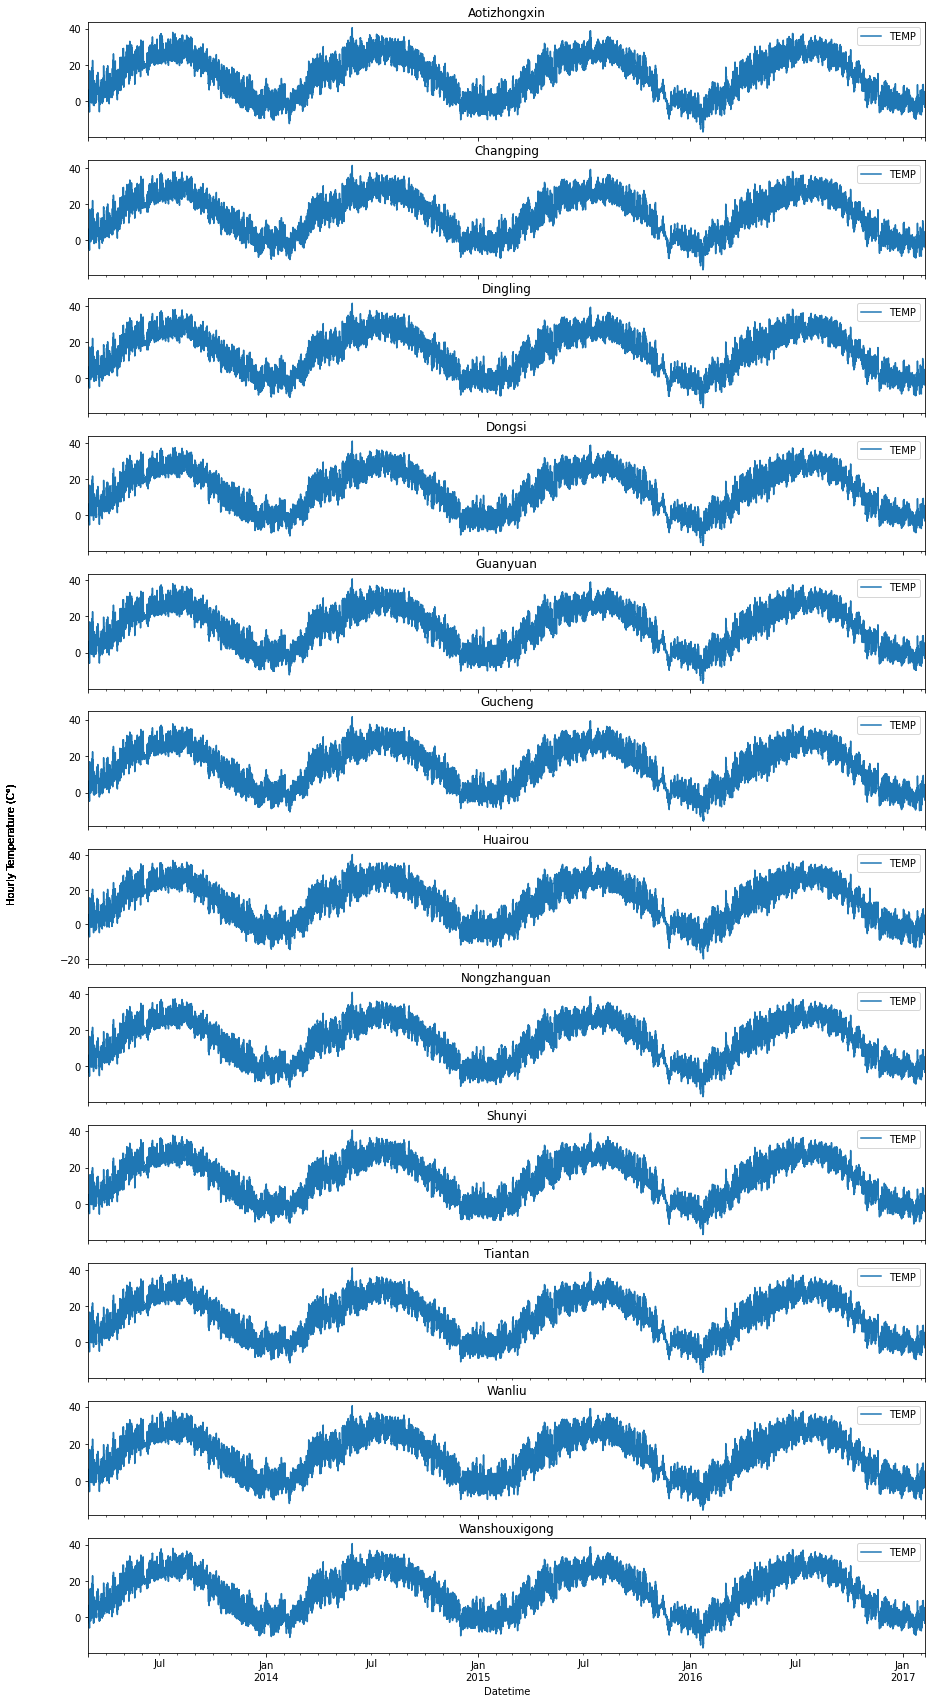

In [131]:
fig, axs = plt.subplots(len(df_regions), 1, figsize=(15, 30), sharex=True)

for i in range(len(df_regions)):
    
    df_forecast_train[df_forecast_train["station"] == df_regions[i]].plot(x='timestamp', y='TEMP', ax = axs[i])
    
    axs[i].set_title(f"{df_regions[i]}")
    fig.text(0.05, 0.5, 'Hourly Temperature (C°)', va='center', rotation='vertical')
    axs[i].set_xlabel("Datetime") 
    
plt.plot()

[]

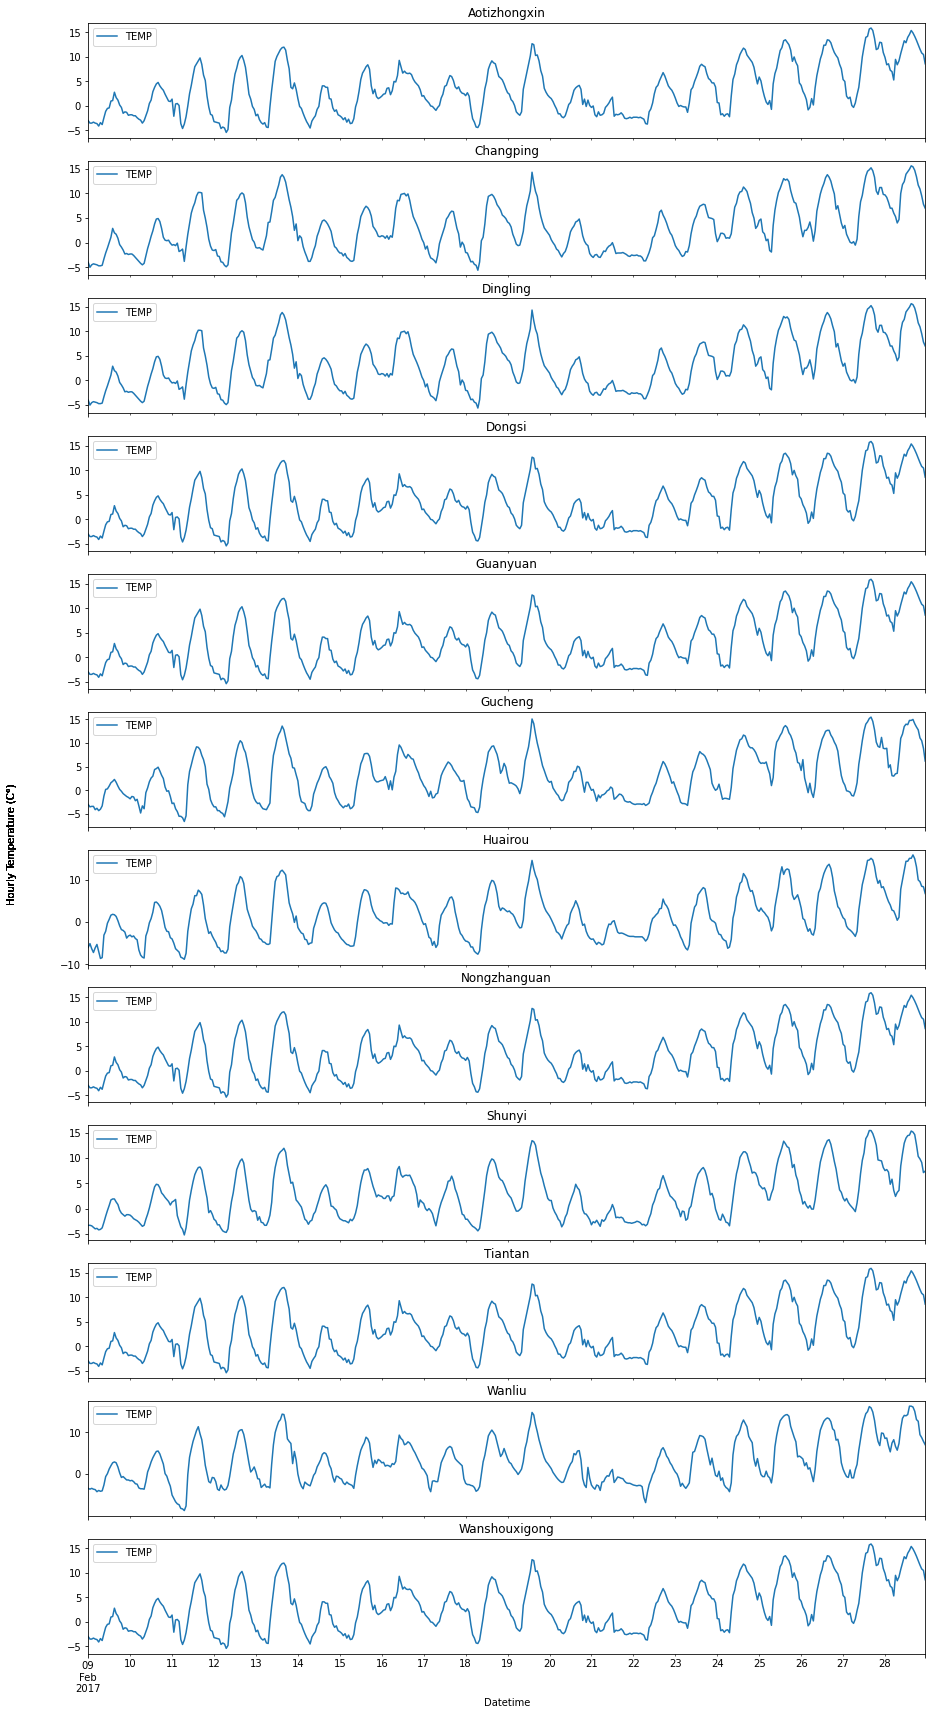

In [12]:
fig, axs = plt.subplots(len(df_regions), 1, figsize=(15, 30), sharex=True)

for i in range(len(df_regions)):
    
    df_forecast_test[df_forecast_test["station"] == df_regions[i]].plot(x='timestamp', y='TEMP', ax = axs[i])
    
    axs[i].set_title(f"{df_regions[i]}")
    fig.text(0.05, 0.5, 'Hourly Temperature (C°)', va='center', rotation='vertical')
    axs[i].set_xlabel("Datetime") 
    
plt.plot()

In [13]:
df_forecast_train.to_csv("data/weather-forecast-train.csv", header= False, index= False)
df_forecast_train.to_csv("data/weather-forecast-test.csv", header= False, index= False)

# S3 Bucket Upload

In [14]:
s3_bucket = "byj"
s3_client = boto3.client("s3")
file_name = "weather-forecast-train.csv"

In [15]:
s3_client.upload_file(f"data/{file_name}", s3_bucket, file_name)

# Create Dataset Group

In [16]:
project_name = "weather_demo"
version = 2
s3_bucket = "byj"

In [17]:
dataset_group = f"{project_name}_{version}"
ds_arns = []
create_dataset_group_response = forecast.create_dataset_group(
    Domain="CUSTOM",
    DatasetGroupName=dataset_group,
    DatasetArns=ds_arns)
ds_group_arn = create_dataset_group_response['DatasetGroupArn']
forecast.describe_dataset_group(DatasetGroupArn=ds_group_arn)

{'DatasetGroupName': 'weather_demo_2',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:688520471316:dataset-group/weather_demo_2',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2022, 7, 7, 2, 1, 24, 623000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2022, 7, 7, 2, 1, 24, 623000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'be0d10d2-16e3-48f2-a1bb-dc0f0fe5d88f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 07 Jul 2022 02:01:24 GMT',
   'x-amzn-requestid': 'be0d10d2-16e3-48f2-a1bb-dc0f0fe5d88f',
   'content-length': '251',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Define Meta Data of Dataset

In [18]:
FORECAST_HORIZON = 480 #24 Hours * 20 Days
DATASET_FREQ = "H"
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

# Schema

In [19]:
SCHEMA ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

# Create Dataset

In [20]:
ds_name = f"{project_name}_{version}"

response = forecast.create_dataset(Domain="CUSTOM",
                        DatasetType='TARGET_TIME_SERIES',
                        DatasetName=ds_name,
                        DataFrequency=DATASET_FREQ,
                        Schema=SCHEMA)

ds_arn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=ds_arn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:688520471316:dataset/weather_demo_2',
 'DatasetName': 'weather_demo_2',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2022, 7, 7, 2, 1, 24, 816000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2022, 7, 7, 2, 1, 24, 816000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '03aedab5-c3ae-4903-9a91-f355f243a051',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 07 Jul 2022 02:01:24 GMT',
   'x-amzn-requestid': '03aedab5-c3ae-4903-9a91-f355f243a051',
   'content-length': '489',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [21]:
ds_arns = []
ds_arns.append(ds_arn)
forecast.update_dataset_group(DatasetGroupArn=ds_group_arn, DatasetArns=ds_arns)

{'ResponseMetadata': {'RequestId': 'f3920888-f9da-4234-96da-88a05548ace3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 07 Jul 2022 02:01:24 GMT',
   'x-amzn-requestid': 'f3920888-f9da-4234-96da-88a05548ace3',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Import Dataset to Bucket

In [23]:
s3_path = f"s3://{bucket_name}/{file_name}"

ds_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=ds_name,
                                        DatasetArn=ds_arn,
                                        DataSource= {
                                            "S3Config": {
                                                "Path": s3_path,
                                                "RoleArn": role_arn
                                            } 
                                        },
                                        TimestampFormat=TIMESTAMP_FORMAT)

ds_import_job_arn = ds_import_job_response['DatasetImportJobArn']
ds_import_job_arn

'arn:aws:forecast:us-east-1:688520471316:dataset-import-job/weather_demo_2/weather_demo_2'

# Create Predictor

In [31]:
predictor_name = f"{project_name}_{version}_autoML_test"
algorithmArn = "arn:aws:forecast:::algorithm/Deep_AR_Plus"

In [32]:
create_predictor_response = forecast.create_predictor(PredictorName= predictor_name, 
    ForecastHorizon= FORECAST_HORIZON,
    PerformAutoML= True,
    PerformHPO= False,
    InputDataConfig= {"DatasetGroupArn": ds_group_arn},
    FeaturizationConfig= {"ForecastFrequency": "H"}
)

In [33]:
predictor_arn= create_predictor_response['PredictorArn']

In [37]:
forecast.get_accuracy_metrics(PredictorArn= predictor_arn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 2.8317033953833173,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.31019352425028884},
       {'Quantile': 0.5, 'LossValue': 0.6721518743033252},
       {'Quantile': 0.1, 'LossValue': 0.2502348624395608}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.6681883328580177,
        'RMSE': 2.8317033953833173,
        'MASE': 1.0802103289104947,
        'MAPE': 2.1916484443980653}],
      'AverageWeightedQuantileLoss': 0.41086008699772497}},
    {'TestWindowStart': datetime.datetime(2017, 1, 20, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2017, 2, 9, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 12,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 2.831703395383317,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.31019352425028884}

# Create Forecast

In [34]:
forecast_name = f"{project_name}_{version}_autoML_forecast"

In [36]:
create_forecast_response = forecast.create_forecast(ForecastName = forecast_name, PredictorArn = predictor_arn)
forecast_arn = create_forecast_response['ForecastArn']

# Get Results

In [50]:
forecast_response = forecastquery.query_forecast(ForecastArn= forecast_arn,
                                                 Filters={"item_id": df_regions[0]})

In [53]:
print(forecast_response)

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2017-02-09T00:00:00', 'Value': -5.27083584937102}, {'Timestamp': '2017-02-09T01:00:00', 'Value': -4.507444722819712}, {'Timestamp': '2017-02-09T02:00:00', 'Value': -6.050870897311704}, {'Timestamp': '2017-02-09T03:00:00', 'Value': -5.814948059176787}, {'Timestamp': '2017-02-09T04:00:00', 'Value': -6.8880690965207005}, {'Timestamp': '2017-02-09T05:00:00', 'Value': -6.824686838145605}, {'Timestamp': '2017-02-09T06:00:00', 'Value': -6.473177235465774}, {'Timestamp': '2017-02-09T07:00:00', 'Value': -6.321461187358123}, {'Timestamp': '2017-02-09T08:00:00', 'Value': -4.439651259024266}, {'Timestamp': '2017-02-09T09:00:00', 'Value': -2.8091457434907854}, {'Timestamp': '2017-02-09T10:00:00', 'Value': -1.3503183633266493}, {'Timestamp': '2017-02-09T11:00:00', 'Value': 0.6469321507250005}, {'Timestamp': '2017-02-09T12:00:00', 'Value': 1.1724483500837528}, {'Timestamp': '2017-02-09T13:00:00', 'Value': 1.414564904712785}, {'Timestamp': '2017-02-

In [43]:
forecast_export_name = f"{project_name}_{version}_autoML_forecast_export"
query_path = f"s3://{bucket_name}/export"

In [44]:
forecast_export_response = forecast.create_forecast_export_job(ForecastExportJobName = forecast_export_name,
                                                                ForecastArn=forecast_arn, 
                                                                Destination = {
                                                                    "S3Config" : {
                                                                        "Path": query_path,
                                                                        "RoleArn": role_arn
                                                                    } 
                                                                })

forecast_export_arn = forecast_export_response["ForecastExportJobArn"]

In [55]:
s3_client.list_objects(Bucket= s3_bucket, Prefix= "output")

{'ResponseMetadata': {'RequestId': 'AKBA0JR8GXGKNK5J',
  'HostId': 'KV3Vi9C3rBBNoGMErHqUWFzTRSJHSGjlGHB1j7SJvW6zVAQE4kkU7/ZIc8CfRXFuVqR48ewAG5w=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'KV3Vi9C3rBBNoGMErHqUWFzTRSJHSGjlGHB1j7SJvW6zVAQE4kkU7/ZIc8CfRXFuVqR48ewAG5w=',
   'x-amz-request-id': 'AKBA0JR8GXGKNK5J',
   'date': 'Thu, 07 Jul 2022 13:58:23 GMT',
   'x-amz-bucket-region': 'us-east-1',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Name': 'byj',
 'Prefix': 'output',
 'MaxKeys': 1000,
 'EncodingType': 'url'}

In [87]:
s3 = boto3.resource('s3')
os.makedirs("export")

In [88]:
for obj in s3.Bucket(s3_bucket).objects.filter(Prefix = "export"):
    path, filename = os.path.split(obj.key)
    if filename.endswith(".csv"):
        s3.Bucket(s3_bucket).download_file(obj.key, f"export/{filename}")

In [126]:
df_results = pd.concat([pd.read_csv(f"export/{filename}") for filename in os.listdir("export")])

In [127]:
print(df_results)
print(df_results.dtypes)

           item_id                  date       p10       p50       p90
0        changping  2017-02-09T00:00:00Z -5.442276 -1.067426  2.775701
1        changping  2017-02-09T01:00:00Z -6.002305 -1.601829  2.251605
2        changping  2017-02-09T02:00:00Z -6.771002 -2.181991  2.028307
3        changping  2017-02-09T03:00:00Z -6.477089 -2.476987  1.376067
4        changping  2017-02-09T04:00:00Z -8.215575 -2.837021  0.963131
...            ...                   ...       ...       ...       ...
1435  nongzhanguan  2017-02-28T19:00:00Z  0.223143  4.603116  8.337601
1436  nongzhanguan  2017-02-28T20:00:00Z -0.234361  3.876660  6.935297
1437  nongzhanguan  2017-02-28T21:00:00Z -2.054518  3.547067  6.975159
1438  nongzhanguan  2017-02-28T22:00:00Z -2.766695  2.344609  6.967652
1439  nongzhanguan  2017-02-28T23:00:00Z -2.474416  1.837242  5.848068

[5760 rows x 5 columns]
item_id     object
date        object
p10        float64
p50        float64
p90        float64
dtype: object


In [128]:
df_results["date"] = pd.to_datetime(df_results["date"]).dt.tz_localize(None)
df_results["item_id"] = df_results["item_id"].str.capitalize()

In [129]:
print(df_results)

           item_id                date       p10       p50       p90
0        Changping 2017-02-09 00:00:00 -5.442276 -1.067426  2.775701
1        Changping 2017-02-09 01:00:00 -6.002305 -1.601829  2.251605
2        Changping 2017-02-09 02:00:00 -6.771002 -2.181991  2.028307
3        Changping 2017-02-09 03:00:00 -6.477089 -2.476987  1.376067
4        Changping 2017-02-09 04:00:00 -8.215575 -2.837021  0.963131
...            ...                 ...       ...       ...       ...
1435  Nongzhanguan 2017-02-28 19:00:00  0.223143  4.603116  8.337601
1436  Nongzhanguan 2017-02-28 20:00:00 -0.234361  3.876660  6.935297
1437  Nongzhanguan 2017-02-28 21:00:00 -2.054518  3.547067  6.975159
1438  Nongzhanguan 2017-02-28 22:00:00 -2.766695  2.344609  6.967652
1439  Nongzhanguan 2017-02-28 23:00:00 -2.474416  1.837242  5.848068

[5760 rows x 5 columns]


# Evaluating Performance

[]

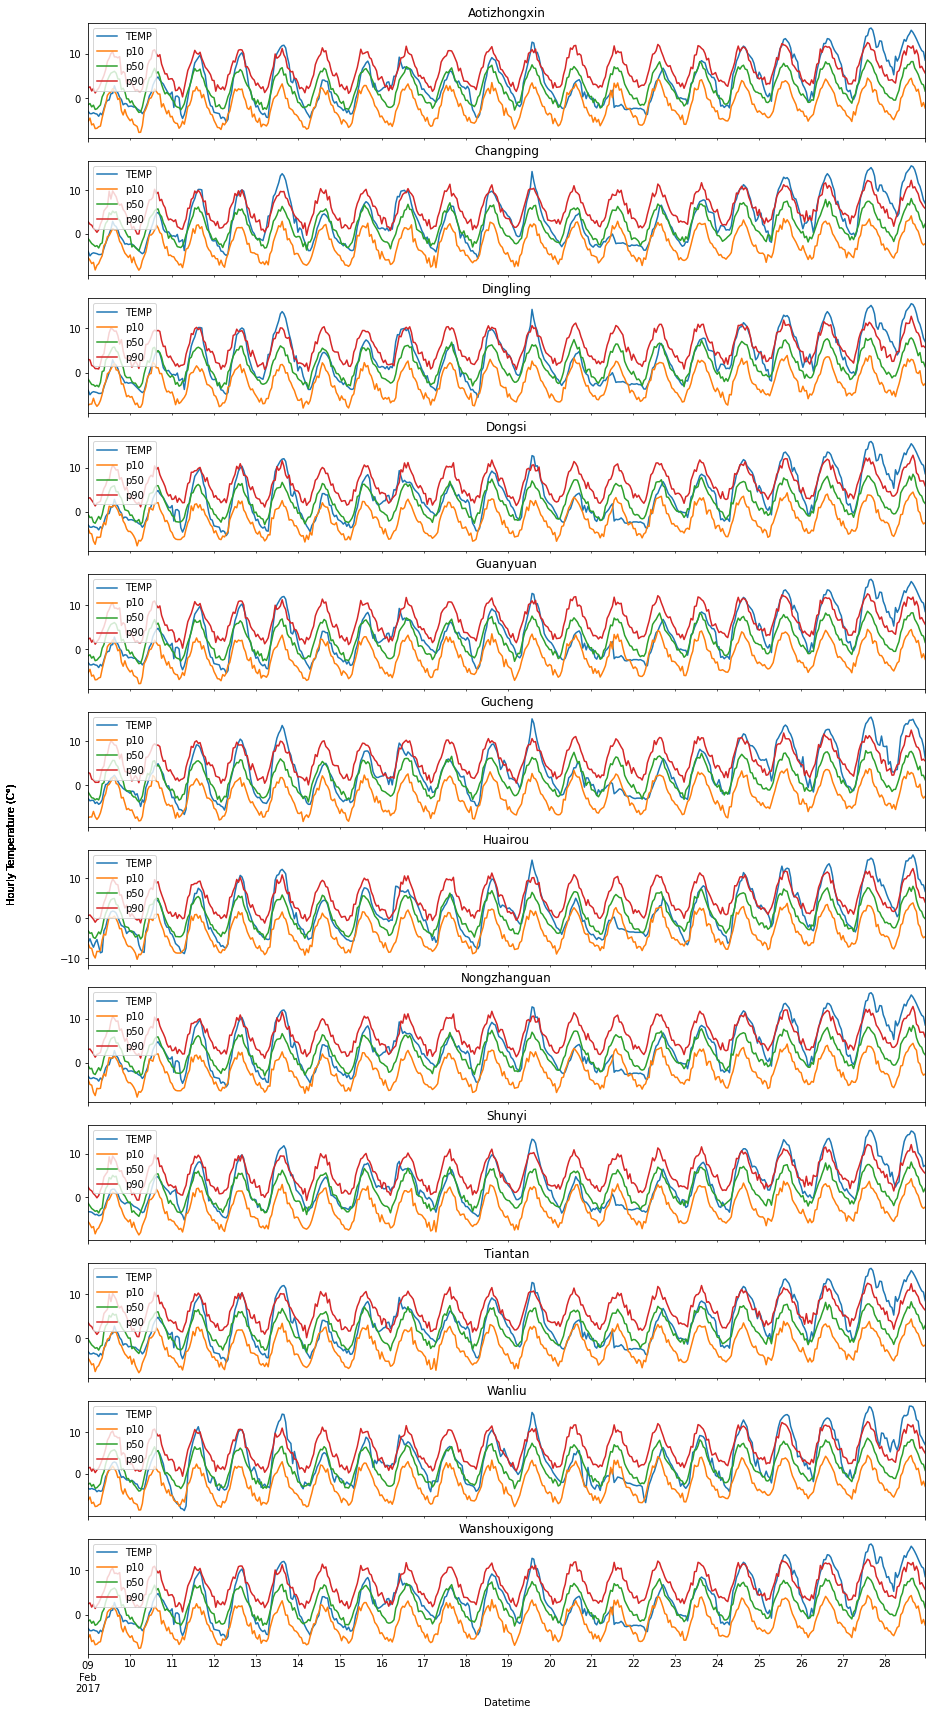

In [136]:
fig, axs = plt.subplots(len(df_regions), 1, figsize=(15, 30), sharex=True)

for i in range(len(df_regions)):
    
    df_forecast_test[df_forecast_test["station"] == df_regions[i]].plot(x='timestamp', y='TEMP', ax = axs[i])
    df_results[df_results["item_id"] == df_regions[i]].plot(x='date', y='p10', ax = axs[i])
    df_results[df_results["item_id"] == df_regions[i]].plot(x='date', y='p50', ax = axs[i])
    df_results[df_results["item_id"] == df_regions[i]].plot(x='date', y='p90', ax = axs[i])
    
    axs[i].set_title(f"{df_regions[i]}")
    fig.text(0.05, 0.5, 'Hourly Temperature (C°)', va='center', rotation='vertical')
    axs[i].set_xlabel("Datetime") 
    
plt.plot()

In [141]:
import gluonts

In [154]:
print(f"Absolute Error for Quantile 0.10: {gluonts.evaluation.metrics.abs_error(df_forecast_test['TEMP'].to_numpy(), df_results['p10'].to_numpy())}")
print(f"Absolute Error for Quantile 0.50: {gluonts.evaluation.metrics.abs_error(df_forecast_test['TEMP'].to_numpy(), df_results['p50'].to_numpy())}")
print(f"Absolute Error for Quantile 0.90: {gluonts.evaluation.metrics.abs_error(df_forecast_test['TEMP'].to_numpy(), df_results['p90'].to_numpy())}")

Absolute Error for Quantile 0.10: 30751.933322780114
Absolute Error for Quantile 0.50: 16761.09451722481
Absolute Error for Quantile 0.90: 22406.107400927023


In [156]:
print(f"MSE for Quantile 0.10: {gluonts.evaluation.metrics.mse(df_forecast_test['TEMP'].to_numpy(), df_results['p10'].to_numpy())}")
print(f"MSE for Quantile 0.50: {gluonts.evaluation.metrics.mse(df_forecast_test['TEMP'].to_numpy(), df_results['p50'].to_numpy())}")
print(f"MSE for Quantile 0.90: {gluonts.evaluation.metrics.mse(df_forecast_test['TEMP'].to_numpy(), df_results['p90'].to_numpy())}")

MSE for Quantile 0.10: 39.37730232405547
MSE for Quantile 0.50: 13.371330360594355
MSE for Quantile 0.90: 21.552383124675426
